# PROJECT 4 - UDACITY DATA ANALYST NANODEGREE PROGRAM
# Wrangle and Data Analyze

# Table of Contents

- [Gatherin Data](#gather)
- [Assessing Data](#assess)
- [Cleaning Data](#cleaning)
- [Storing, Analyzing and Visualizing Data](#store)

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import os
import json as js
import tweepy
from timeit import default_timer as timer
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

<a id='gather'></a>
# Gathering Data
1. The WeRateDogs Twitter archive. `twitter_archive_enhanced.csv` manually downloaded from udacity 

2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file `image_predictions.tsv` is hosted on Udacity's servers and will be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

3. Each tweet's retweet count and favorite ("like") count. Using the tweet IDs in the WeRateDogs Twitter archive, we query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called `tweet_json.txt` file. Each tweet's JSON data is written to its own line. Then this .txt file is read line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count

In [3]:
# 1. Gathering data from `twitter-archive-enhanced.csv`
df1 = pd.read_csv('twitter-archive-enhanced.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
# 2. Downloading image_predictions.tsv from Udacity's servers programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = rq.get(url)
response

<Response [200]>

In [5]:
file_name2 = url.split('/')[-1]
with open(file_name2, mode = 'wb') as file:
    file.write(response.content)

In [6]:
df2 = pd.read_csv(file_name2, sep ='\t')
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [8]:
# 3. Query the Twitter API for each tweet's JSON data using Tweepy library
# and store each tweet's entire set of JSON data in a file called tweet_json.txt
tweet_id = df1.tweet_id

i = 0
fails = []

start = timer()

with open('tweet_json.txt', 'w') as outfile:

    for tweet in tweet_id:
        i+=1
        print(str(i) + ": " + str(tweet))
        try:
            tweet = api.get_status(tweet, tweet_mode='extended')
            print("Success")
            js.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("No tweet found for {} with error message {}".format(str(tweet), str(e)))
            fails.append(tweet)
            pass
        
end = timer()
print(end - start, ' sec')
        


1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
No tweet found for 888202515573088257 with error message [{'code': 144, 'message': 'No status found with that ID.'}]
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
3

Success
230: 848212111729840128
Success
231: 847978865427394560
Success
232: 847971574464610304
Success
233: 847962785489326080
Success
234: 847842811428974592
Success
235: 847617282490613760
Success
236: 847606175596138505
Success
237: 847251039262605312
Success
238: 847157206088847362
Success
239: 847116187444137987
Success
240: 846874817362120707
Success
241: 846514051647705089
Success
242: 846505985330044928
Success
243: 846153765933735936
Success
244: 846139713627017216
Success
245: 846042936437604353
Success
246: 845812042753855489
Success
247: 845677943972139009
Success
248: 845459076796616705
No tweet found for 845459076796616705 with error message [{'code': 144, 'message': 'No status found with that ID.'}]
249: 845397057150107648
Success
250: 845306882940190720
Success
251: 845098359547420673
Success
252: 844979544864018432
Success
253: 844973813909606400
Success
254: 844704788403113984
No tweet found for 844704788403113984 with error message [{'code': 144, 'message': 'No stat

Success
464: 817423860136083457
Success
465: 817415592588222464
Success
466: 817181837579653120
Success
467: 817171292965273600
Success
468: 817120970343411712
Success
469: 817056546584727552
Success
470: 816829038950027264
Success
471: 816816676327063552
Success
472: 816697700272001025
Success
473: 816450570814898180
Success
474: 816336735214911488
Success
475: 816091915477250048
Success
476: 816062466425819140
Success
477: 816014286006976512
Success
478: 815990720817401858
Success
479: 815966073409433600
Success
480: 815745968457060357
Success
481: 815736392542261248
Success
482: 815639385530101762
Success
483: 815390420867969024
Success
484: 814986499976527872
Success
485: 814638523311648768
Success
486: 814578408554463233
Success
487: 814530161257443328
Success
488: 814153002265309185
Success
489: 813944609378369540
Success
490: 813910438903693312
Success
491: 813812741911748608
Success
492: 813800681631023104
Success
493: 813217897535406080
Success
494: 813202720496779264
Success


Success
715: 784057939640352768
Success
716: 783839966405230592
Success
717: 783821107061198850
Success
718: 783695101801398276
Success
719: 783466772167098368
Success
720: 783391753726550016
Success
721: 783347506784731136
Success
722: 783334639985389568
Success
723: 783085703974514689
Success
724: 782969140009107456
Success
725: 782747134529531904
Success
726: 782722598790725632
Success
727: 782598640137187329
Success
728: 782305867769217024
Success
729: 782021823840026624
Success
730: 781955203444699136
Success
731: 781661882474196992
Success
732: 781655249211752448
Success
733: 781524693396357120
Success
734: 781308096455073793
Success
735: 781251288990355457
Success
736: 781163403222056960
Success
737: 780931614150983680
Success
738: 780858289093574656
Success
739: 780800785462489090
Success
740: 780601303617732608
Success
741: 780543529827336192
Success
742: 780496263422808064
Success
743: 780476555013349377
Success
744: 780459368902959104
Success
745: 780192070812196864
Success


Rate limit reached. Sleeping for: 719


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Success
1150: 726828223124897792
Success
1151: 726224900189511680
Success
1152: 725842289046749185
Success
1153: 725786712245440512
Success
1154: 725729321944506368
Success
1155: 725458796924002305
Success
1156: 724983749226668032
Success
1157: 724771698126512129
Success
1158: 724405726123311104
Success
1159: 724049859469295616
Success
1160: 724046343203856385
Success
1161: 724004602748780546
Success
1162: 723912936180330496
Success
1163: 723688335806480385
Success
1164: 723673163800948736
Success
1165: 723179728551723008
Success
1166: 722974582966214656
Success
1167: 722613351520608256
Success
1168: 721503162398597120
Success
1169: 721001180231503872
Success
1170: 720785406564900865
Success
1171: 720775346191278080
Success
1172: 720415127506415616
Success
1173: 720389942216527872
Success
1174: 720340705894408192
Success
1175: 720059472081784833
Success
1176: 720043174954147842
Success
1177: 719991154352222208
Success
1178: 719704490224398336
Success
1179: 719551379208073216
Success
11

Success
1400: 699691744225525762
Success
1401: 699446877801091073
Success
1402: 699434518667751424
Success
1403: 699423671849451520
Success
1404: 699413908797464576
Success
1405: 699370870310113280
Success
1406: 699323444782047232
Success
1407: 699088579889332224
Success
1408: 699079609774645248
Success
1409: 699072405256409088
Success
1410: 699060279947165696
Success
1411: 699036661657767936
Success
1412: 698989035503689728
Success
1413: 698953797952008193
Success
1414: 698907974262222848
Success
1415: 698710712454139905
Success
1416: 698703483621523456
Success
1417: 698635131305795584
Success
1418: 698549713696649216
Success
1419: 698355670425473025
Success
1420: 698342080612007937
Success
1421: 698262614669991936
Success
1422: 698195409219559425
Success
1423: 698178924120031232
Success
1424: 697995514407682048
Success
1425: 697990423684476929
Success
1426: 697943111201378304
Success
1427: 697881462549430272
Success
1428: 697630435728322560
Success
1429: 697616773278015490
Success
14

Success
1650: 683742671509258241
Success
1651: 683515932363329536
Success
1652: 683498322573824003
Success
1653: 683481228088049664
Success
1654: 683462770029932544
Success
1655: 683449695444799489
Success
1656: 683391852557561860
Success
1657: 683357973142474752
Success
1658: 683142553609318400
Success
1659: 683111407806746624
Success
1660: 683098815881154561
Success
1661: 683078886620553216
Success
1662: 683030066213818368
Success
1663: 682962037429899265
Success
1664: 682808988178739200
Success
1665: 682788441537560576
Success
1666: 682750546109968385
Success
1667: 682697186228989953
Success
1668: 682662431982772225
Success
1669: 682638830361513985
Success
1670: 682429480204398592
Success
1671: 682406705142087680
Success
1672: 682393905736888321
Success
1673: 682389078323662849
Success
1674: 682303737705140231
Success
1675: 682259524040966145
Success
1676: 682242692827447297
Success
1677: 682088079302213632
Success
1678: 682059653698686977
Success
1679: 682047327939461121
Success
16

Rate limit reached. Sleeping for: 716


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
2062: 671166507850801152
Success
2063: 671163268581498880
Success
2064: 671159727754231808
Success
2065: 671154572044468225
Success
2066: 671151324042559489
Success
2067: 671147085991960577
Success
2068: 671141549288370177
Success
2069: 671138694582165504
Success
2070: 671134062904504320
Success
2071: 671122204919246848
Success
2072: 671115716440031232
Success
2073: 671109016219725825
Success
2074: 670995969505435648
Success
2075: 670842764863651840
Success
2076: 670840546554966016
Success
2077: 670838202509447168
Success
2078: 670833812859932673
Success
2079: 670832455012716544
Success
2080: 670826280409919488
Success
20

Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
2311: 666786068205871104
Success
2312: 666781792255496192
Success
2313: 666776908487630848
Success
2314: 666739327293083650
Success
2315: 666701168228331520
Success
2316: 666691418707132416
Success
2317: 666649482315059201
Success
2318: 666644823164719104
Success
2319: 666454714377183233
Success
2320: 666447344410484738
Success
2321: 666437273139982337
Success
2322: 666435652385423360
Success
2323: 666430724426358785
Success
2324: 666428276349472768
Success
2325: 666421158376562688
Success
2326: 666418789513326592
Success
2327: 666411507551481857
Success
2328: 666407126856765440
Success
2329: 666396247373291520
Success
2330: 666373753744588802
Success
23

In [9]:
# Checking the total no of ids we had and the no of the one missing
len(tweet_id),len(fails)

(2356, 25)

In [10]:
# Retrieving the tweets 
tweets = []
for line in open('tweet_json.txt', 'r'):
    tweets.append(js.loads(line))

In [11]:
# Read tweet ID, retweet count, and favorite count into a Pandas dataframe
tweet_id = []
retweet_count = []
favorite_count = []

for i in range(len(tweets)):
    tweet_id.append(tweets[i]['id'])
    retweet_count.append(tweets[i]['retweet_count'])
    favorite_count.append(tweets[i]['favorite_count'])
    
d = {'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count':favorite_count}
df3 = pd.DataFrame(data=d)

df3

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7719,36256
1,892177421306343426,5705,31261
2,891815181378084864,3781,23539
3,891689557279858688,7869,39530
4,891327558926688256,8492,37748
...,...,...,...
2326,666049248165822465,39,96
2327,666044226329800704,132,272
2328,666033412701032449,41,112
2329,666029285002620928,42,121


In [12]:
len(tweets)

2331

In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


<a id='assess'></a>
# Assessing Data
In this section, we assess the 3 data frames we obtained above, visually, and programmatically for quality and tidiness issues.

The goal is to detect and document at least eight (8) quality issues and two (2) tidiness issues to address key requirements for this project as below:

- We only want original ratings (no retweets) that have images. Though there are 2356 tweets in the dataset, not all are dog ratings and some are retweets.

- Merging individual pieces of data according to the rules of tidy data.

Assessing df1 for:
 - The ratings
 - The dog names
 - The dog stages

In [14]:
# General info on df1 

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [16]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
df1.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
           ... 
Ralphus       1
Ben           1
Olaf          1
Crawford      1
Comet         1
Name: name, Length: 957, dtype: int64

In [18]:
df1.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [19]:
# General info on df2
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
df2.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [21]:
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [22]:
# General info on df3
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [23]:
df3.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [24]:
df3.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7719,36256
1,892177421306343426,5705,31261
2,891815181378084864,3781,23539
3,891689557279858688,7869,39530
4,891327558926688256,8492,37748


In [25]:
df3.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2707.727585,7569.594595
std,6.823170e+16,4578.866796,11747.278952
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,548.000000,1319.500000
50%,7.182469e+17,1269.000000,3294.000000
75%,7.986692e+17,3146.500000,9265.500000
max,8.924206e+17,77931.000000,156370.000000


## Quality issue observations
### df1 (twitter-archive-enhanced.csv)
- `rating_numerator` has outliers with min = 0 and max = 1776
- `rating_denumerator` has outliers with min = 0 and max = 170
- dog stage can be categorial 
- `Null` represent as `None` in dog stage, could be melt into one column
- 745 dog names are missing
- 55 dogs named as `a`
- potential for duplicate names such as Charlie, Lucy, Cooper or more (to be investigated)
- `timestamp` datatype incorrect
- 181 of the tweets are retweeted as there is value for `retweeted_status_id` 
- `df1` has 281 more tweets with images than `df2`  
- `df1`, `df2` and `df3` need to be merged at the end

## Tidiness issue observations
### df1 (twitter-archive-enhanced.csv)
- convert the dog stage 4 columns to one column representing the stage

### df2 (image_predictions.tsv)
- predicted dog names are inconsistent on the first letter 
- only the dog information for the highest probability needed

<a id='cleaning'></a>
# Cleaning Data


## Define

### Tidiness issues
1. fix the dog stage columns by putting them all into one column
2. make the dog names consistent in `df2`
3. drop the columns related to the second and third rank predictions in `df2`

### Quality issues
1. fix outliers in `rating_numerator`  in df1
2. fix outliers in `rating_denumerator` in conjunction with `rating_numerator` by calculating the actual rating
3. make dog stage categorial 
4. `Null` represent as `None` in dog stage
5. 745 dog names are missing, 55 dogs named as `a` and the rest as `None'
6. Fix dog names listed as `None`
7. Potential for duplicate names such as Charlie, Lucy, Cooper or more (to be investigated)
8. Fix `timestamp` datatype 
9. Drop 181 `retweeted_status_id`
10. Merge `df1`, `df2` and `df3`
11. 11.	Drop the tweets that do not have images and retweeted

## Code

In [26]:
# Making copy of the 3 dataframes for cleaning purpose
df1_clean = df1.copy()
df2_clean = df2.copy()
df3_clean = df3.copy()

In [27]:
df1_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Tidiness no 1: convert the dog stage 4 columns to one column representing the stage in df1

In [28]:
# Converting the cells with `None` to empty string
df1_clean['doggo'].replace('None', '', inplace=True)
df1_clean['floofer'].replace('None', '', inplace=True)
df1_clean['pupper'].replace('None', '', inplace=True)
df1_clean['puppo'].replace('None', '', inplace=True)

df1_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,


In [29]:
# convert the dog stage 4 columns to one column representing the stage

df1_clean['stage'] = df1_clean['doggo'] + df1_clean['floofer'] + df1_clean['pupper'] + df1_clean['puppo'] 
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [30]:
# Testing how the operation worked
df1_clean.stage.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [31]:
# Formatting the rows with multiple stages
df1_clean.loc[df1_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper'
df1_clean.loc[df1_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo'
df1_clean.loc[df1_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

In [32]:
# Testing how the operation worked
df1_clean.stage.value_counts()

                 1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

In [33]:
# dropping the old columns
df1_clean = df1_clean.drop(['doggo','floofer','pupper','puppo' ], axis = 1)
df1_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


#### Tidiness no 2: predicted dog names inconsistent with the first letter capital/lower case in df2


In [34]:
# Vewing df2
df2_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [35]:
# Making the dog names consistent
df2_clean.p1 = df2_clean.p1.str.title()
df2_clean.p2 = df2_clean.p2.str.title()
df2_clean.p3 = df2_clean.p3.str.title()


df2_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [36]:
# Taking a look at the predictions confidence
df2_clean[['p1_conf','p2_conf','p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


#### Tidiness no 3: Dropping the columns related to the second and third rank predictions in df2

In [37]:
# Triming df2 to the dog name with highest confidence in predictions
df2_clean = df2_clean.drop(['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1)

df2_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True


In [38]:
# Looking into p1_dog which represents whether or not the prediction is a breed of dog
df2_clean.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [39]:
# The algorithm didn't recognize 543 entries as a valid breed of dog
# Looking into the rows where the predicted name is not a breed of dog
df2_clean[df2_clean.p1_dog == False].sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
935,703407252292673536,https://pbs.twimg.com/media/CcMBJODUsAI5-A9.jpg,1,Doormat,0.201058,False
512,676215927814406144,https://pbs.twimg.com/media/CWJmzNsWUAE706Z.jpg,1,Hamster,0.999484,False
1892,849336543269576704,https://pbs.twimg.com/media/C8lzFC4XcAAQxB4.jpg,1,Patio,0.521788,False
1716,819006400881917954,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,Prison,0.907083,False
1443,775729183532220416,https://pbs.twimg.com/media/CsPxk85XEAAeMQj.jpg,1,Web_Site,0.989407,False
1016,709901256215666688,https://pbs.twimg.com/media/CdoTbL_XIAAitq2.jpg,2,Bib,0.998814,False
217,670069087419133954,https://pbs.twimg.com/media/CUyQRzHWoAAhF1D.jpg,1,Boathouse,0.313829,False
1375,763103485927849985,https://pbs.twimg.com/media/CpcWknPXYAAeLP9.jpg,2,Seat_Belt,0.685821,False
246,670474236058800128,https://pbs.twimg.com/media/CU4AwqQWUAAEgE2.jpg,1,Wool,0.070076,False
1240,746906459439529985,https://pbs.twimg.com/media/Cl2LdofXEAATl7x.jpg,1,Traffic_Light,0.470708,False


#### Looking at some of those link reveals that some of them may be truely dogs however the complexity of the image have led to the algorithm not being able to identify the breed. We can leave them as is and take note when we do analysis

#### Quality issue no 1: fix outliers in `rating_numerator`  in df1

In [40]:
# First we look at the series from greatest to the smallest numbers
df1_clean.rating_numerator.sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
        ... 
2338       1
2261       1
2335       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

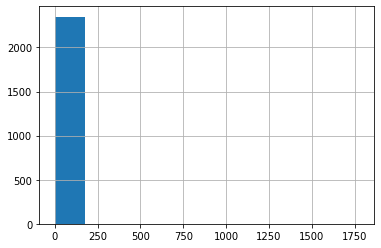

In [41]:
# It looks like there are some large numbers in rating_numerator, let's plot and see the distribution
df1_clean.rating_numerator.hist();

In [42]:
# The distribution shows a big abnormality, proving there are outliers. We can quantify this by .describe() method
df1_clean.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [43]:
# Sorting rating_numerator
df1_clean.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Seems there are multiple `rating_numerator` with high number, so maybe they are true numbers, let's have a look at one of them


In [44]:
# Checking the rating_numerator with the highest number

df1_clean[df1_clean.rating_numerator == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,


In [45]:
# It appears normal, let's have a look at the picture of this dog in df2_clean 
df2_clean[df2_clean.tweet_id==749981277374128128]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
1270,749981277374128128,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1,Bow_Tie,0.533941,False


#### Clicing on the link, still we don't find anything strong enough to reject this entry, we could leave this as is and look at the `rating_denominator`

#### Quality issue no 2: fix outliers in `rating_denumerator`  in df1

In [46]:
# Looking at rating_denominator

df1_clean.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [47]:
# rating_denominator seems it is mostly 10 with some outlier, let's dig deeper into it
df1_clean.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

#### There are a few problems here with `rating_denominator`
- There is a 0 in there which is invalid so this needs to be cleaned
- There is 2333 entries as 10 which is following the rating convention. The rest being 2356 - 2333 = 23 entries are not 10 we could drop these value with justification that they do not follow the rating convention


In [48]:
# Dropping the entries where rating_denominator is not equal to 10
df1_clean = df1_clean.drop(df1_clean[df1_clean.rating_denominator != 10].index, axis = 0)
df1_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

In [49]:
# Adding a column to df1_clean with the calculated rating = rating_numerator / rating_denominator
df1_clean['rating'] = df1_clean.rating_numerator / df1_clean.rating_denominator

In [50]:
# Testing the new 'rating' column 
df1_clean.rating.describe()

count    2333.000000
mean        1.223746
std         4.102247
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

In [51]:
# Testing the new 'rating' column 
df1_clean.rating.value_counts()

1.2      558
1.1      463
1.0      461
1.3      351
0.9      156
0.8      102
0.7       54
1.4       54
0.5       37
0.6       32
0.3       19
0.4       15
0.2        9
0.1        8
0.0        2
42.0       2
1.5        2
7.5        2
66.6       1
2.6        1
177.6      1
18.2       1
1.7        1
2.7        1
Name: rating, dtype: int64

#### It looks like most of the ratings are between 0.1 at lower end and 1.4 at the upper end so we can go ahead and cut the values outside of this range for analysis. We can extend the upper hand to 2 to capture a few more ratings

In [52]:
# Cutting out the outliers in df1_clean.rating
indecies_todrop = df1_clean[(df1_clean.rating >= 2) | (df1_clean.rating <= 0.1) ].index
df1_clean = df1_clean.drop(indecies_todrop, axis = 0)


In [53]:
# Testing df1_clean after cleaning 'rating' column 

df1_clean.rating.value_counts()

1.2    558
1.1    463
1.0    461
1.3    351
0.9    156
0.8    102
0.7     54
1.4     54
0.5     37
0.6     32
0.3     19
0.4     15
0.2      9
1.5      2
1.7      1
Name: rating, dtype: int64

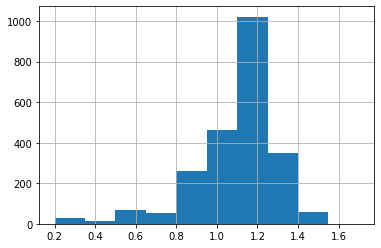

In [54]:
# Having a look at the rating distribution
df1_clean.rating.hist();

The `rating` as shown above looks more plausable and we will use this for the analysis

#### Quality issue no 3: make dog `stage` categorial  in df1

In [55]:
# categorizing the stage column
df1_clean.stage = df1_clean.stage.astype('category')

In [56]:
# testing the df1_clean.stage
df1_clean.dtypes

tweet_id                         int64
in_reply_to_status_id          float64
in_reply_to_user_id            float64
timestamp                       object
source                          object
text                            object
retweeted_status_id            float64
retweeted_status_user_id       float64
retweeted_status_timestamp      object
expanded_urls                   object
rating_numerator                 int64
rating_denominator               int64
name                            object
stage                         category
rating                         float64
dtype: object

#### Quality issue no 4: `Null` was represented as `None` in dog stage which was fixed in Tidiness issue # 1 above

#### Quality issue no 5: 745 dog names are missing some listed as `a` others as `None`
Let's deal with dogs named as `a` first

In [57]:
# checking the dog names 
df1_clean.name.value_counts()

None        713
a            54
Charlie      12
Lucy         11
Cooper       11
           ... 
Bloop         1
Ralphus       1
Olaf          1
Crawford      1
Eazy          1
Name: name, Length: 953, dtype: int64

In [58]:
#Look into dublicated dog names
df1_clean.name.duplicated().sum()

1361

In [59]:
# cheking for Null names
df1_clean.name.isnull().sum()

0

#### It appaers there are a 54 dog names appeared as `a` and also 713 names as `None`. This says perhaps the name extraction from the tweets had some issues getting the actual names. Let's have a look at the dogs identified as `a`

In [60]:
a_names = df1_clean[df1_clean.name == 'a']
a_names.text
a_name = []
for i in a_names.text:
    a_name.append(i)
    
a_name

['Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF',
 'Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq',
 'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn',
 'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW',
 'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R',
 'This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2',
 'This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKC

#### From the list above generated from the dog names as `a` we see a few patterns that were missed. These are the new patterns we found via search for "name" using MsWord 
- `named SOMETHING` x19 | Expression: `^.*?named (\w+)`
- Seems the original expression used for this section searches for `is a ` which didn't work for all the tweet texts


#### We can repeat the same procedure as above with the dog names as "None" and find other possible patterns


In [61]:
none_names = df1_clean[df1_clean.name == 'None']
n_name = []
for i in none_names.text:
    n_name.append(i)
    
n_name

["Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh",
 "When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq",
 "Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm",
 'You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV',
 'This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp',
 '@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution',
 'RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo',
 'I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk',
 'Here we have a corgi undercover a

##### New Patterns - searched via MsWord with keyword "name"
- `his name is SOMETHING`
- `Her name is SOMETHING`
- `named SOMETHING`
- `His name is SOMETHING` 
- `This pup's name is SOMETHING` 

- The two expression that could be used to take these names out are `name is` and `named ` which is expressed above.

    1. `^.*?name is\s(\w+)` 
    2. `^.*?named (\w+)`
    
It seems it is possible to retreive at least 28 names from the tweets using these patterns so we can try to do this 

In [62]:
# Replacing the names where the name is 'a' with the extracted name. Where unsuccessfull, 'Nan' would be put in place
df1_clean['name1'] = df1_clean[df1_clean.name == 'a'].text.str.extract(r'^.*?named (\w+)')

In [63]:
# Testing for the extracted names
df1_clean.name1.value_counts()

Cherokee     1
Hemry        1
Cheryl       1
Johm         1
Klint        1
Octaviath    1
Pepe         1
Alphred      1
Chuk         1
Jessiga      1
Alfonso      1
Jacob        1
Rufus        1
Kohl         1
Wylie        1
Spork        1
Alfredo      1
Leroi        1
Kip          1
Name: name1, dtype: int64

In [64]:
# cheking for Null names
df1_clean.name.isnull().sum()

0

#### We will try the same procedure for the names listes as `None`

#### Quality issue no 6: Fix dogs names as listed as `None`

In [65]:
# Code test for replacement of the names where the name is 'None' with the extracted name. Where unsuccessfull, 'Nan' would be put in place
df1_clean['name2'] = df1_clean[df1_clean.name == 'None'].text.str.extract(r'^.*?name is (\w+)')
df1_clean['name3'] = df1_clean[df1_clean.name == 'None'].text.str.extract(r'^.*?named (\w+)')

In [66]:
#Testing
print(df1_clean['name2'].unique() ,df1_clean['name3'].unique())

[nan 'Howard' 'Zoey' 'Charley' 'Thea' 'Sabertooth' 'Big'] [nan 'Tickles' 'Zeus' 'Guss']


In [67]:
# Filling Nan's with empty string for concatenation
df1_clean.name = df1_clean.name.replace(np.nan, '', regex=True)
df1_clean.name1 = df1_clean.name1.replace(np.nan, '', regex=True)
df1_clean.name2 = df1_clean.name2.replace(np.nan, '', regex=True)
df1_clean.name3 = df1_clean.name3.replace(np.nan, '', regex=True)

In [68]:
# Replacing names `a` and `None` with empty string
df1_clean.name = df1_clean.name.replace('a', '', regex=False)
df1_clean.name = df1_clean.name.replace('None', '', regex=False)


In [69]:
# Concatenate the newly extracted names to the `name_comb` column
df1_clean['name_comb'] = df1_clean[['name', 'name1', 'name2','name3']].apply(lambda x: ''.join(x), axis=1)

In [70]:
# Testing for the cleaned `name` column
df1_clean.name_comb.value_counts()

           738
Charlie     12
Lucy        11
Oliver      11
Cooper      11
          ... 
Rinna        1
Toffee       1
Ralphus      1
Bert         1
Comet        1
Name: name_comb, Length: 975, dtype: int64

In [71]:
# Testing
print(df1_clean['name'].nunique())
print(df1_clean['name1'].nunique())
print(df1_clean['name2'].nunique())
print(df1_clean['name3'].nunique())
print(df1_clean['name_comb'].nunique())

952
20
7
4
975


In [72]:
# Droping the extra columns
df1_clean = df1_clean.drop(['name','name1','name2','name3'], axis = 1)

In [73]:
# Renaming the column
df1_clean.rename(columns={"name_comb": "name"}, inplace = True)

# Testing
df1_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,stage,rating,name
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,,1.3,Phineas
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,,1.3,Tilly
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,,1.2,Archie
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,,1.3,Darla
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,,1.2,Franklin


In [74]:
# Testing for the 'name'
print(df1_clean['name'].nunique())

975


In [75]:
# checking the dog names once more
df1_clean.name.value_counts()

           738
Charlie     12
Lucy        11
Oliver      11
Cooper      11
          ... 
Rinna        1
Toffee       1
Ralphus      1
Bert         1
Comet        1
Name: name, Length: 975, dtype: int64

#### Quality issue no 7: potential for duplicate names such as `Charlie`, `Lucy`, `Cooper` or more (to be investigated) and fixed

In [76]:
# Let's have a look at the tweet text for dog name `Charlie` and see if that reveals anything 
df1_clean[df1_clean.name == 'Charlie'].text

230     RT @dog_rates: This is Charlie. He fell asleep...
254     This is Charlie. He wants to know if you have ...
261     This is Charlie. He's wishing you a very fun a...
326     Meet Charlie. She asked u to change the channe...
338     This is Charlie. He fell asleep on a heating v...
383     This is Charlie. He wins every game of chess h...
813     This is Charlie. He works for @TODAYshow. Supe...
932     This is Charlie. He pouts until he gets to go ...
1358    This is Charlie. He's a West Side Niddlewog. M...
1436    Meet Charlie. He likes to kiss all the big mil...
1682    Say hello to Charlie. He's scholarly af. Quite...
2049    This is Charlie. He was just informed that dog...
Name: text, dtype: object

In [77]:
df1_clean[df1_clean.name == 'Oliver'].text

15      This is Oliver. You're witnessing one of his m...
301     Say hello to Oliver. He's pretty exotic. Fairl...
438     RT @dog_rates: This is Oliver. He has dreams o...
439     This is Oliver. He has dreams of being a servi...
916     This is Oliver. He's an English Creamschnitzel...
1034    This is Oliver. He's downright gorgeous as hel...
1168    This is Oliver. Bath time is upon him. His fea...
1287    This is Oliver. That is his castle. He protect...
1318    This is Oliver (pronounced "Ricardo"). He's a ...
1411    This is Oliver. He does toe touches in his sle...
1876    Say hello to Oliver. He thought what was insid...
Name: text, dtype: object

#### It appears there are some limited retweets but overall it seems the names are legitly repeated becasue they are just popular names for dogs 

In [78]:
# Let's check how many of the repeated names are actually retweets
df1_clean[df1_clean.retweeted_status_id == df1_clean.retweeted_status_id].name.value_counts()

           62
Bo          3
Lola        2
Sunny       2
Maddie      2
           ..
Moreton     1
Gidget      1
Oliver      1
Meyer       1
Leela       1
Name: name, Length: 109, dtype: int64

#### It appears not too many of high repeat names are actually retweet (62 counts). We will drop the retweets later in step # 9 so for now we leave it as is

#### Quality issue no 8: Fix `timestamp` datatype 


In [79]:
# Conversion of `timestamp` to datetime
df1_clean.timestamp = pd.to_datetime(df1_clean.timestamp)

#Testing
df1_clean.dtypes

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp                 object
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
stage                                    category
rating                                    float64
name                                       object
dtype: object

#### Quality issue no 9: Drop rows with `retweeted_status_id`


In [80]:
# Dropping the rows that are retweeted
df1_clean = df1_clean.drop(df1_clean[df1_clean.retweeted_status_id == df1_clean.retweeted_status_id].index, axis = 0)


In [81]:
# Testing for the retweets
df1_clean[df1_clean.retweeted_status_id == df1_clean.retweeted_status_id]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,stage,rating,name


In [82]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2136 non-null   int64              
 1   in_reply_to_status_id       66 non-null     float64            
 2   in_reply_to_user_id         66 non-null     float64            
 3   timestamp                   2136 non-null   datetime64[ns, UTC]
 4   source                      2136 non-null   object             
 5   text                        2136 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2088 non-null   object             
 10  rating_numerator            2136 non-null   int64           

#### Quality issue no 10: Merge `df1` , `df2` and `df3`

In [83]:
# Merging `df1_clean` and `df2_clean`
df12 = pd.merge(df1_clean, df2_clean, on='tweet_id')
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1964
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1965 non-null   int64              
 1   in_reply_to_status_id       21 non-null     float64            
 2   in_reply_to_user_id         21 non-null     float64            
 3   timestamp                   1965 non-null   datetime64[ns, UTC]
 4   source                      1965 non-null   object             
 5   text                        1965 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1965 non-null   object             
 10  rating_numerator            1965 non-null   int64           

In [84]:
# Merging `df12` and `df3_clean` to combine all together into one dataframe
df_clean = pd.merge(df12, df3_clean, on='tweet_id')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 0 to 1957
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1958 non-null   int64              
 1   in_reply_to_status_id       21 non-null     float64            
 2   in_reply_to_user_id         21 non-null     float64            
 3   timestamp                   1958 non-null   datetime64[ns, UTC]
 4   source                      1958 non-null   object             
 5   text                        1958 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1958 non-null   object             
 10  rating_numerator            1958 non-null   int64           

#### Quality issue no 11: Initial plan was to drop the tweets that don't have images and looking at the results above after merging all 3 datasets it seems every entries has an image attached to it so we check for the possible duplicate images 

In [85]:
# Checking for the number of duplicates in `jpg_url`
df_clean.jpg_url.duplicated().sum()

0

No duplicate image found, which is good.

In [86]:
# Additional test on the images 
df_clean.jpg_url.value_counts().describe()

count    1958.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: jpg_url, dtype: float64

#### The dataframe now looks pretty clean. We would just need to drop the unnecessary columns as they are not needed, the columns to drop are
- `in_reply_to_status_id` , `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` , `retweeted_status_timestamp`

In [87]:
# Dropping the empty columns and testing
df_clean = df_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis = 1)

df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,stage,rating,name,jpg_url,img_num,p1,p1_conf,p1_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,,1.3,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,7719,36256
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,,1.3,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,5705,31261
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,,1.2,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,3781,23539
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,,1.3,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_Towel,0.170278,False,7869,39530
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,,1.2,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,8492,37748


In [88]:
# Final look at the cleaned dataframe - looking at database
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 0 to 1957
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1958 non-null   int64              
 1   timestamp           1958 non-null   datetime64[ns, UTC]
 2   source              1958 non-null   object             
 3   text                1958 non-null   object             
 4   expanded_urls       1958 non-null   object             
 5   rating_numerator    1958 non-null   int64              
 6   rating_denominator  1958 non-null   int64              
 7   stage               1958 non-null   category           
 8   rating              1958 non-null   float64            
 9   name                1958 non-null   object             
 10  jpg_url             1958 non-null   object             
 11  img_num             1958 non-null   int64              
 12  p1                  1958 non-null 

In [89]:
# Final look at the cleaned dataframe - looking for possible nulls
df_clean.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
stage                 0
rating                0
name                  0
jpg_url               0
img_num               0
p1                    0
p1_conf               0
p1_dog                0
retweet_count         0
favorite_count        0
dtype: int64

In [90]:
# Final look at the cleaned dataframe - looking at the data types
df_clean.dtypes

tweet_id                            int64
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
stage                            category
rating                            float64
name                               object
jpg_url                            object
img_num                             int64
p1                                 object
p1_conf                           float64
p1_dog                               bool
retweet_count                       int64
favorite_count                      int64
dtype: object

In [91]:
# Final look at the cleaned dataframe - checking for dublicates
df_clean.duplicated().sum()

0

In [92]:
# Final look at the cleaned dataframe - looking at numerics statistics
df_clean.describe()

,tweet_id,rating_numerator,rating_denominator,rating,img_num,p1_conf,retweet_count,favorite_count
count,1.958000e+03,1958.000000,1958.0,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000
mean,7.358806e+17,10.573034,10.0,1.057303,1.203269,0.592986,2454.146578,8284.908069
std,6.759774e+16,2.119459,0.0,0.211946,0.561542,0.271938,4407.670331,12224.234245
min,6.660209e+17,2.000000,10.0,0.200000,1.000000,0.044333,11.000000,71.000000
25%,6.758041e+17,10.000000,10.0,1.000000,1.000000,0.360226,548.000000,1770.250000
50%,7.082494e+17,11.000000,10.0,1.100000,1.000000,0.587357,1176.500000,3717.000000
75%,7.881228e+17,12.000000,10.0,1.200000,1.000000,0.843016,2797.750000,10290.750000
max,8.924206e+17,14.000000,10.0,1.400000,4.000000,1.000000,77931.000000,156370.000000


#### The dataframe now looks good and we are ready to move on to the storing, analysing and visualizing

<a id='store'></a>
# Storing, Analyzing and Visualizing Data

## Storing into a new 'CSV file

In [93]:
# Storing the cleaned data frame as CSV
df_clean.to_csv('twitter_archive_master.csv',index=False)

## Analyzing and Visualizating

### Let's think of some interesting questions to ask about this database


Questions:
1. Which names are the most popular dog name?
- Which breeds are the most popular breed?
- What are the 5 top rated breeds?
- What are the 5 top retweeted breeds?  
- What are the 5 top favorite breeds?  
- Which dog had the most retweet counts?
- Which dog had the most favorite counts?
- Which dog had the highest rating?
- What is the dog stage distribution?

In [94]:
# 1. Which names are the most popular dog name?
top_5_popular_names = df_clean.name.value_counts().head(6)[1:]
top_5_popular_names

Oliver     10
Charlie    10
Cooper     10
Lucy        9
Tucker      9
Name: name, dtype: int64

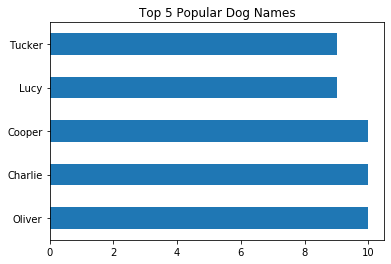

In [95]:
top_5_popular_names.plot(kind = 'barh', title = 'Top 5 Popular Dog Names');

In [96]:
# 2. Which breeds are the most popular breed?
top_5_popular_breeds = df_clean.p1.value_counts().head(5)
top_5_popular_breeds

Golden_Retriever      135
Labrador_Retriever     90
Pembroke               88
Chihuahua              79
Pug                    54
Name: p1, dtype: int64

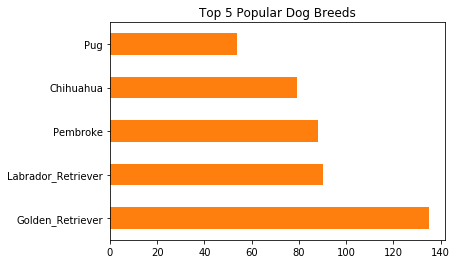

In [97]:
top_5_popular_breeds.plot(kind = 'barh', title = 'Top 5 Popular Dog Breeds', color = 'C1');

In [98]:
#3. What are the 5 top rated breeds?

#Sorting the dataframe by their rating
df_rating_sorted = df_clean.sort_values(by=['rating'], ascending=False)

In [99]:
# Skipping the enteries where the prediction did not match a real dog bread and getting the top breads
top_5_rated_breeds = df_rating_sorted[df_rating_sorted.p1_dog == True][['p1','rating']].head()
top_5_rated_breeds

,p1,rating
318,Gordon_Setter,1.4
327,Standard_Poodle,1.4
152,Black-And-Tan_Coonhound,1.4
308,Pomeranian,1.4
146,Chihuahua,1.4


In [100]:
#4. What are the 5 top retweeted breeds?
df_retweet_count_sorted = df_clean.sort_values(by=['retweet_count'], ascending=False)

In [101]:
# Skipping the enteries where the prediction did not match a real dog bread and getting the top retweeted breads
top_5_retweeted_breeds = df_retweet_count_sorted[df_retweet_count_sorted.p1_dog == True][['p1','retweet_count']].head()
top_5_retweeted_breeds

,p1,retweet_count
761,Labrador_Retriever,77931
795,Eskimo_Dog,57765
393,Chihuahua,56814
304,Lakeland_Terrier,43892
58,English_Springer,40611


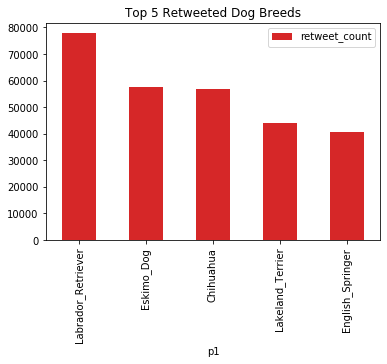

In [102]:
ax1 = top_5_retweeted_breeds.plot.bar(x='p1', y='retweet_count', rot=90, title = 'Top 5 Retweeted Dog Breeds', color = 'C3')

In [103]:
# 5. What are the 5 top favorite breeds?
df_favorite_count_sorted = df_clean.sort_values(by=['favorite_count'], ascending=False)
top_5_favorite_breeds = df_favorite_count_sorted[df_favorite_count_sorted.p1_dog == True][['p1','favorite_count']].head()
top_5_favorite_breeds

,p1,favorite_count
761,Labrador_Retriever,156370
304,Lakeland_Terrier,133192
393,Chihuahua,120830
107,French_Bulldog,116543
795,Eskimo_Dog,115516


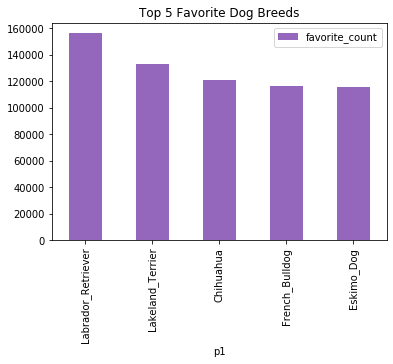

In [104]:
ax2 = top_5_favorite_breeds.plot.bar(x='p1', y='favorite_count', rot=90, title = 'Top 5 Favorite Dog Breeds', color = 'C4')

In [105]:
# 6. Which dog had the most retweet counts?
top_retweet = df_retweet_count_sorted.head(1)
top_retweet

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,stage,rating,name,jpg_url,img_num,p1,p1_conf,p1_dog,retweet_count,favorite_count
761,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,doggo,1.3,,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,Labrador_Retriever,0.825333,True,77931,156370


In [106]:
# Summary of this entry
top_retweet[['rating','name','jpg_url','p1','retweet_count']]

,rating,name,jpg_url,p1,retweet_count
761,1.3,,https://pbs.twimg.com/ext_tw_video_thumb/74423...,Labrador_Retriever,77931


In [107]:
# 7. Which dog had the most favorite counts?
top_favorite = df_favorite_count_sorted.head(1)
top_favorite

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,stage,rating,name,jpg_url,img_num,p1,p1_conf,p1_dog,retweet_count,favorite_count
761,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,doggo,1.3,,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,Labrador_Retriever,0.825333,True,77931,156370


In [108]:
# 8. Which dog had the highest rating?
top_rated = df_rating_sorted.head(1)
top_rated

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,stage,rating,name,jpg_url,img_num,p1,p1_conf,p1_dog,retweet_count,favorite_count
318,820314633777061888,2017-01-14 17:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",We are proud to support @LoveYourMelon on thei...,"https://www.loveyourmelon.com/pages/ourstory,h...",14,10,,1.4,,https://pbs.twimg.com/media/C2JXyARUAAE4gbL.jpg,2,Gordon_Setter,0.940724,True,572,3388


In [109]:
top_rated.jpg_url.values[0]

'https://pbs.twimg.com/media/C2JXyARUAAE4gbL.jpg'

#### Displaying the image of the highest rated dog
![top_dog](https://pbs.twimg.com/media/C2JXyARUAAE4gbL.jpg)

In [110]:
# 9. What is the dog stage distribution?
dog_stage = df_clean.stage.value_counts()[1:]
dog_stage

pupper           202
doggo             62
puppo             22
doggo,pupper       9
floofer            7
doggo,puppo        1
doggo,floofer      1
Name: stage, dtype: int64

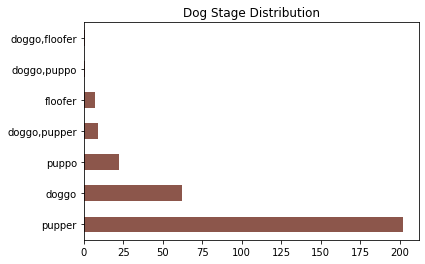

In [111]:
# Plotting the dog stage
dog_stage.plot(kind = 'barh', title = 'Dog Stage Distribution', color = 'C5');
